In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [115]:
data_root = './preprocessing/new_data.csv'

In [116]:
df = pd.read_csv(data_root)
df = df[['sentence', 'label']]
df

,sentence,label
0,希望台灣會更好大推這篇！！推,Non-offensive
1,下面沒人要跟土城找安囉,Non-offensive
2,0每個小瑕疵看起來都很細微過高屏溪都殺人無罪了,Non-offensive
3,淪落到連打一個教嗚嗚嗚，好可憐，都是柯P霸凌慣犯阿苗怎麼不幫幫你的苗粉快去死吧！政治蟑螂直接...,Non-offensive
4,但是司法你以綠能你不能啦要就全國一起玩台南感覺更哇，把新竹選民當白癡耍是第一天認識民進黨？還沒就職,Non-offensive
...,...,...
917,"在那叫什麼""",Offensive
918,現在天天幹妳娘臭B選完希望母豬能辭職現在警界升遷被喬來喬去，1126台幣市民會給大家史上最傲...,Offensive
919,綠共什麼鍋配什麼蓋,Offensive
920,去你的高端法說會支持讀稿機,Offensive


In [117]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

737 92 93


In [118]:
import torch
import numpy as np
from transformers import BertTokenizer

In [119]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
labels = {'Non-offensive':0,
          'Offensive':1,
          }


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 32, truncation=True,
                                return_tensors="pt") for text in df['sentence']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [120]:
from torch import nn
from transformers import BertModel

In [121]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [122]:
output_model = './models/model_bert.pth'

# save
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

In [123]:
from torch.optim import Adam
from tqdm import tqdm

In [124]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2, drop_last=True)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            save(model, optimizer)
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [125]:
EPOCHS = 3 # 5

model = BertClassifier()
LR = 3e-6 # 1e-6

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [01:35<00:00,  3.87it/s]


Epochs: 1 | Train Loss:  0.341                 | Train Accuracy:  0.502                 | Val Loss:  0.338                 | Val Accuracy:  0.435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [01:34<00:00,  3.91it/s]


Epochs: 2 | Train Loss:  0.306                 | Train Accuracy:  0.624                 | Val Loss:  0.284                 | Val Accuracy:  0.728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [01:34<00:00,  3.90it/s]


Epochs: 3 | Train Loss:  0.193                 | Train Accuracy:  0.858                 | Val Loss:  0.267                 | Val Accuracy:  0.804


In [146]:
y_pred = []
y_true = []

def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = nn.CrossEntropyLoss()
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    total_acc_test = 0
    total_loss_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)            
            _, preds = torch.max(output, 1)
            batch_loss = criterion(output, test_label)
            total_loss_test += batch_loss.item()
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(test_label.view(-1).detach().cpu().numpy())
            
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    print(
            f'Test Accuracy: {total_acc_test / len(test_data): .3f} \
            | Test Loss: {total_loss_test / len(test_data): .3f}')
    
    return y_pred, y_true

In [147]:
y_pred, y_true = evaluate(model, df_test)

Test Accuracy:  0.753             | Test Loss:  0.571


In [161]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [150]:
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)

In [151]:
class_names = ['Non-offensive', 'Offensive']
print(class_names)
print(per_cls_acc)
print('plot confusion matrix')

['Non-offensive', 'Offensive']
[0.75       0.75609756]
plot confusion matrix


In [157]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
plt.figure(figsize = (12, 10))
df_cm = pd.DataFrame(cf_matrix , index = class_names , columns = class_names)

<Figure size 864x720 with 0 Axes>

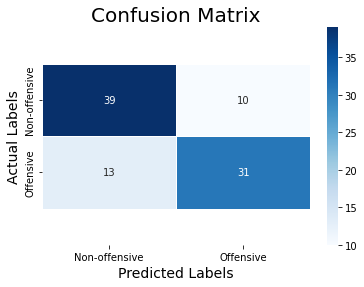

In [159]:
ax = sns.heatmap(df_cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Confusion_Matrix.png')
plt.show()

In [163]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        49
           1       0.76      0.70      0.73        44

    accuracy                           0.75        93
   macro avg       0.75      0.75      0.75        93
weighted avg       0.75      0.75      0.75        93

